#### Part 1: PCA and Variance Threshold in a Linear Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree as t
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2,accuracy_score,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from numpy import array 
import seaborn as sb

Import the housing data as a data frame and ensure that the data is loaded properly.

In [2]:
# Loading csv file into data frame.
hp_df = pd.read_csv('Data/train_hp.csv')
hp_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Drop the "Id" column and any features that are missing more than 40% of their values.

In [3]:
# Calculating missing values percentage.
missing_val = hp_df.isnull().sum() * 100 / len(hp_df)
d = missing_val.to_dict()

# Getting features that have missing values more than 40%.
missing_feat = {k for k,v in d.items() if v > 40}
missing_feat

{'Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC'}

In [4]:
# Removing Id and features that are missing more than 40% of their values.
hp_df.drop(['Id', 'Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC'], axis = 1, inplace=True)

For numerical columns, fill in any missing data with the median value. 

In [5]:
# Getting numeric columns.
numeric_columns = hp_df.select_dtypes(include=['number']).columns

# Filling any missing data with the median value.
for column in numeric_columns:
    median = hp_df[column].median()
    hp_df[column] = hp_df[column].fillna(median)

For categorical columns, fill in any missing data with the most common value (mode).

In [6]:
# Getting category columns.
category_columns = list(set(hp_df.columns)-set(numeric_columns))

# Filling any missing data with the mode value.
for column in category_columns:
    mode = hp_df[column].mode()
    hp_df[column] = hp_df[column].fillna(mode)

In [7]:
# Checking median and mode values.
hp_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
hp_df.shape

(1460, 75)

Convert the categorical columns to dummy variables.

In [9]:
# Using the get_dummies function to create the dummy variables for categorical columns.
hp_df_dummy = pd.get_dummies(hp_df, columns = category_columns)
hp_df_dummy

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,1,0,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


Split the data into a training and test set, where the SalePrice column is the target.

In [10]:
# Creating x and y arrays.
x = hp_df_dummy.drop(['SalePrice'], axis=1)
y = hp_df_dummy['SalePrice']

# Splitting data into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

Run a linear regression and report the R2-value and RMSE on the test set.

In [11]:
# Creating a Linear regression model.
model = LinearRegression()
model.fit(x_train, y_train)

# Test data prediction.
test_predictions = model.predict(x_test)

# Calculating metrics.
print('Test Metrics:')
print('R2', metrics.r2_score(y_test, test_predictions))
print('RMSE', metrics.mean_squared_error(y_test, test_predictions, squared=False))

Test Metrics:
R2 0.8712385939275631
RMSE 30303.779585892407


Fit and transform the training features with a PCA so that 90% of the variance is retained (see section 9.1 in the Machine Learning with Python Cookbook). How many features are in the PCA-transformed matrix?

In [12]:
# Fitting and transforming using PCA
sc = StandardScaler()

x_train_sc = sc.fit_transform(x_train)

pca = PCA(n_components=0.9, whiten=True)

x_train_pca = pca.fit_transform(x_train_sc)

# Comparing the number of features

print("Original No. of features: " + str(x_train_sc.shape))
print("Reduced No. of features: " + str(x_train_pca.shape))

Original No. of features: (1168, 270)
Reduced No. of features: (1168, 139)


There are 139 features

Transform but DO NOT fit the test features with the same PCA.

In [13]:
# Transforming the test data

x_test_scaled = sc.transform(x_test)
x_test_pca = pca.transform(x_test_scaled)

Repeat step 7 with your PCA transformed data.

In [14]:
# Training the new linear regression

new_model_pca = LinearRegression()
new_model_pca.fit(x_train_pca, y_train)

# Testing the data prediction

test_predict_pca = new_model_pca.predict(x_test_pca)

print('PCA Transfromed Data Metrics:')
print('R2', metrics.r2_score(y_test, test_predict_pca))
print('RMSE', metrics.mean_squared_error(y_test, test_predict_pca, squared=False))

PCA Transfromed Data Metrics:
R2 0.8373184990630774
RMSE 34062.226191049434


Take your original training features (from step 6) and apply a min-max scaler to them.
Find the min-max scaled features in your training set that have a variance above 0.1 (see Section 10.1 in the Machine Learning with Python Cookbook). Transform but DO NOT fit the test features with the same steps applied in steps 11 and 12.


In [15]:
# Assigning the MinMaxScaler
min_max = MinMaxScaler()

# Building the training minmax
x_train_minmax = min_max.fit_transform(x_train)

# Assigning the VarianceThreshold
var_thresholder = VarianceThreshold(threshold = 0.1)

# Creating the high variance features matrix
x_train_high_var = var_thresholder.fit_transform(x_train_minmax)

# Applying the minmax to the test features
x_test_minmax = min_max.transform(x_test)

# Creating high variance features matrix
x_test_high_var = var_thresholder.fit_transform(x_test_minmax)

Repeat step 7 with the high variance data.

In [16]:
# Creating a model
high_var_model = LinearRegression()
high_var_model.fit(x_train_high_var, y_train)

LinearRegression()

In [17]:
# Building the predictions
test_predict_high_var = high_var_model.predict(x_test_high_var)

# Calculate metrics
print('Test Metrics:')
print('R2', metrics.r2_score(y_test, test_predict_high_var))
print('RMSE', metrics.mean_squared_error(y_test, test_predict_high_var, squared=False))

Test Metrics:
R2 -0.5137483828462399
RMSE 103903.64648444981


Summarize your findings.

The R-squared values decreased from 87% to 83% for the model when we used the PCA transformed data but the min-max scaler reduced it even further to 57%. However we have seen that the performance of the model did not get impacted much when we used the PCA Transfromed data.

#### Part 2: Categorical Feature Selection

Import the data as a data frame and ensure it is loaded correctly.

In [18]:
# Loading the data
mushroom_df = pd.read_csv('Data/mushrooms.csv')
mushroom_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


Convert the categorical features (all of them) to dummy variables.

In [19]:
# Seperating the class
mushroom_df_class = mushroom_df['class']
mushroom_df = mushroom_df.drop('class', axis=1)

# Creating the dummy variables
mushroom_df_dummies = pd.get_dummies(mushroom_df)
mushroom_df_dummies.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Split the data into a training and test set.

In [20]:
x = mushroom_df_dummies
y = mushroom_df_class

# Creating the training & test datasets
mx_train, mx_test, my_train, my_test = train_test_split(x, y, test_size = 0.2)

Fit a decision tree classifier on the training set.

In [21]:
# Creating the object
dt = DecisionTreeClassifier(random_state=0)

# Training the new model
dt_model = dt.fit(mx_train, my_train)

Report the accuracy and create a confusion matrix for the model prediction on the test set.

In [22]:
# Building the predictions
my_test_pred = dt_model.predict(mx_test)

# Calculating the accuracy
accuracy_score(my_test, my_test_pred)

1.0

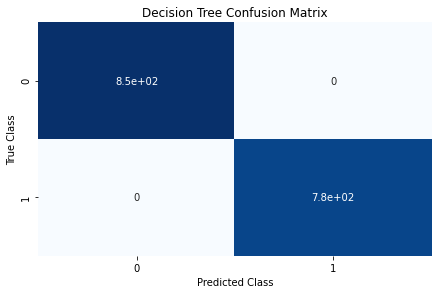

In [23]:
# Creating the confusion matrix
conf_mat = confusion_matrix(my_test, my_test_pred)

c_df = pd.DataFrame(conf_mat)

# Creating the heatmap
sb.heatmap(c_df, annot=True, cbar=None, cmap="Blues")
plt.title("Decision Tree Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Create a visualization of the decision tree.

[Text(196.94117647058823, 203.85, 'X[27] <= 0.5\ngini = 0.499\nsamples = 6499\nvalue = [3361, 3138]'),
 Text(118.16470588235295, 176.67000000000002, 'X[53] <= 0.5\ngini = 0.283\nsamples = 3664\nvalue = [624, 3040]'),
 Text(78.7764705882353, 149.49, 'X[55] <= 0.5\ngini = 0.13\nsamples = 3238\nvalue = [226, 3012]'),
 Text(59.082352941176474, 122.31, 'X[25] <= 0.5\ngini = 0.047\nsamples = 3087\nvalue = [75, 3012]'),
 Text(39.38823529411765, 95.13, 'X[22] <= 0.5\ngini = 0.023\nsamples = 3047\nvalue = [35, 3012]'),
 Text(19.694117647058825, 67.94999999999999, 'gini = 0.0\nsamples = 3012\nvalue = [0, 3012]'),
 Text(59.082352941176474, 67.94999999999999, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(78.7764705882353, 95.13, 'gini = 0.0\nsamples = 40\nvalue = [40, 0]'),
 Text(98.47058823529412, 122.31, 'gini = 0.0\nsamples = 151\nvalue = [151, 0]'),
 Text(157.5529411764706, 149.49, 'X[71] <= 0.5\ngini = 0.123\nsamples = 426\nvalue = [398, 28]'),
 Text(137.85882352941178, 122.31, 'gini = 

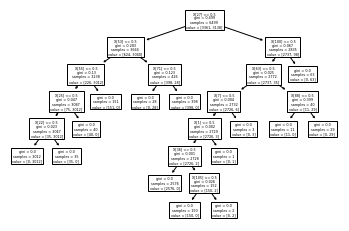

In [24]:
# Plotting the decision tree
t.plot_tree(dt_model)

Use a χ2-statistic selector to pick the five best features for this data (see section 10.4 of the Machine Learning with Python Cookbook). 

In [25]:
# Selecting the 5 features with highest chi-squared statistics
chi2_sel = SelectKBest(chi2, k=5)
feat_kbest = chi2_sel.fit_transform(mx_train, my_train)

Which five features were selected in step 7? Hint: Use the get_support function.

In [26]:
feat = array(mx_train.columns)

# Retrieving selected features
feat_sel = chi2_sel.get_support()

print(feat[feat_sel])

['odor_f' 'odor_n' 'gill-color_b' 'stalk-surface-above-ring_k'
 'stalk-surface-below-ring_k']


Repeat steps 4 and 5 with the five best features selected in step 7.

In [27]:
dt_5 = DecisionTreeClassifier(random_state=0)

dt_5_model = dt_5.fit(feat_kbest, my_train)

dt_5_test = chi2_sel.transform(mx_test)

dt_5_test_pred = dt_5_model.predict(dt_5_test)

accuracy_score(my_test, dt_5_test_pred)

0.9335384615384615

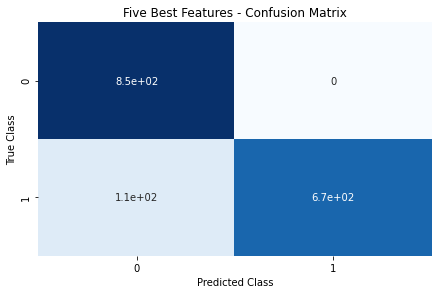

In [28]:
# Creating the confusion matrix
dt_5_matrix = confusion_matrix(my_test, dt_5_test_pred)

# Creating the pandas dataframe
dt5_df = pd.DataFrame(dt_5_matrix)

# Creating the heatmap
sb.heatmap(dt5_df, annot=True, cbar=None, cmap="Blues")
plt.title("Five Best Features - Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Summarize your findings.

The accuracy of the model did not have a big impact by decreasing the features to the best 5. The accuracy went from 100% to 93%. So its not a big difference.